In [1]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
data = dataset[0]
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

`data.x` is just Id_34 matrix. No node information.

`edge_index` - [list of sources, list of endes] `COO format`


In [5]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [10]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# converters to igraph and networkx

In [11]:
# convertion from Data to igraph
import numpy as np
import igraph as ig

karate_edges_list = data.edge_index.T.tolist()
karate_edges_list = [tuple(i) for i in karate_edges_list]

g = ig.Graph()
g.add_vertices(34)
g.add_edges(karate_edges_list)


max_mod = 0
best_comm = []
for _ in range(1000):
    g_comm = g.community_leiden(objective_function="modularity", n_iterations=-1)
    if g_comm.modularity > max_mod:
        max_mod = g_comm.modularity
        best_comm = g_comm.membership

# import csv
# with open('karate_community', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(best_comm)

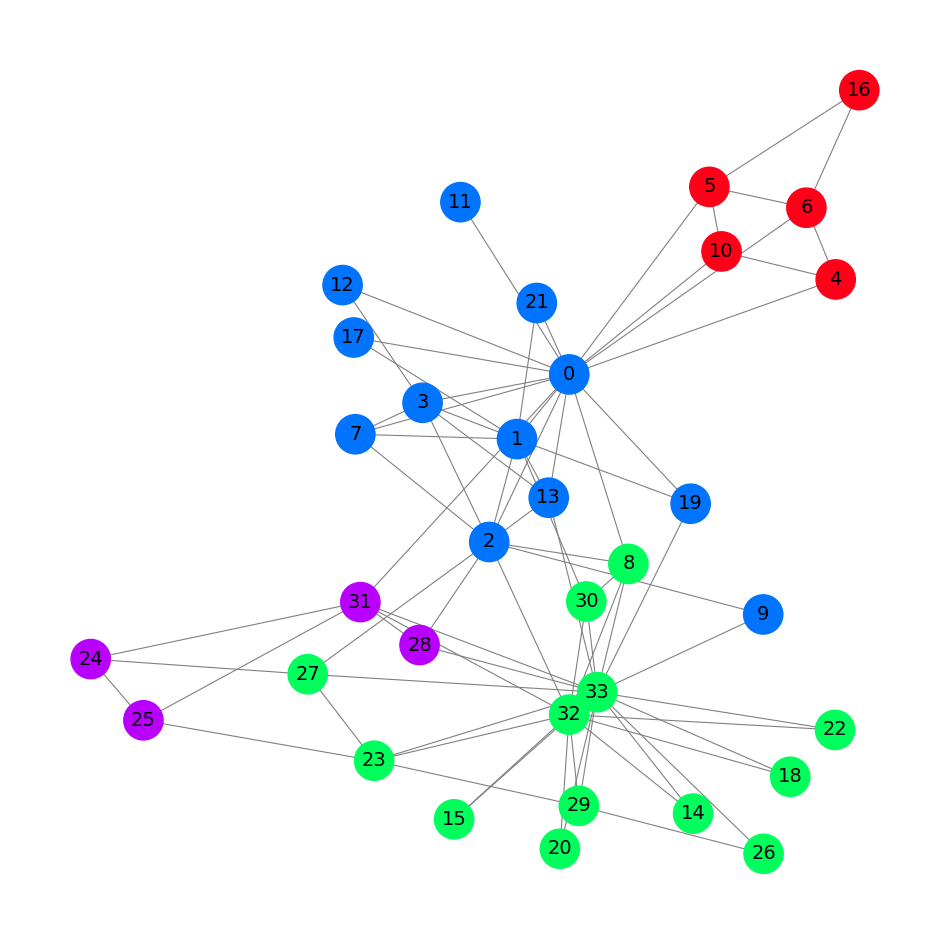

In [13]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

# MLP model 
- there is no node features so MLP model has no sens

- let's add community features


In [22]:
import torch
import pandas as pd

df = pd.read_csv('karate_features.csv')
df_x = df.drop(columns=['node_id']).astype(np.float32)
x = torch.from_numpy(df_x.values)
data.x = x

In [26]:
data

Data(x=[34, 21], edge_index=[2, 156], y=[34], train_mask=[34])

In [31]:
data.train_mask
data.val_mask = ~data.train_mask
data.test_mask = ~data.train_mask

In [41]:
from myNN import MLP
mlp = MLP(data.num_features, 16, 4)
print(mlp)
mlp.fit(data, epochs=50)


MLP(
  (linear1): Linear(in_features=21, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.589 | Train Acc: 25.00% | Val Loss 1.28 | Val Acc: 36.67% 
Epoch  20 | Train Loss: 0.624 | Train Acc: 75.00% | Val Loss 2.13 | Val Acc: 43.33% 
Epoch  40 | Train Loss: 0.146 | Train Acc: 100.00% | Val Loss 3.92 | Val Acc: 13.33% 


In [42]:
acc = mlp.test(data)
print(f'MLP test accuracy: {acc*100:.2f}%')

MLP test accuracy: 20.00%


In [39]:
from myNN import GCN
gcn2 = GCN(data.num_features, 16, 4)
print(gcn2)
gcn2.fit(data, epochs=100)

GCN(
  (conv1): GCNConv(21, 16)
  (conv2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 7.177 | Train Acc: 25.00% | Val Loss 7.67 | Val Acc: 36.67% 
Epoch  20 | Train Loss: 1.056 | Train Acc: 50.00% | Val Loss 1.06 | Val Acc: 53.33% 
Epoch  40 | Train Loss: 1.376 | Train Acc: 25.00% | Val Loss 1.36 | Val Acc: 36.67% 
Epoch  60 | Train Loss: 1.175 | Train Acc: 25.00% | Val Loss 1.30 | Val Acc: 30.00% 
Epoch  80 | Train Loss: 0.654 | Train Acc: 100.00% | Val Loss 1.19 | Val Acc: 43.33% 
Epoch 100 | Train Loss: 0.570 | Train Acc: 100.00% | Val Loss 1.19 | Val Acc: 43.33% 


In [40]:
acc_gcn2 = gcn2.test(data)
print(f'GCN test accuracy: {acc_gcn2*100:.2f}%')

GCN test accuracy: 46.67%


In [79]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh() 
        out = self.classifier(h)

        return out, h

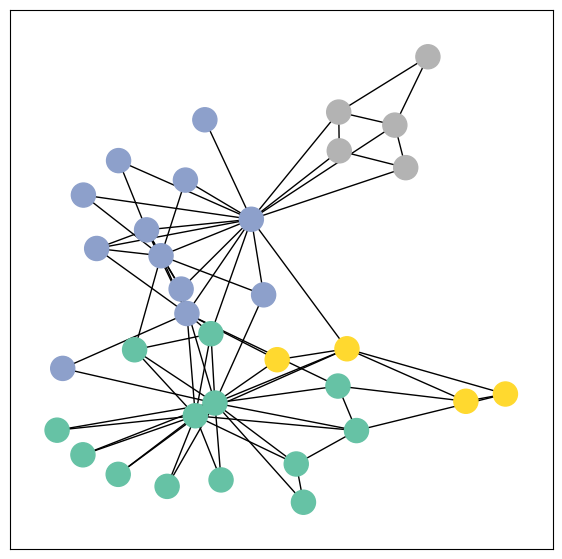

In [69]:
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=42),
                 with_labels=False,
                 node_color=data.y,
                 cmap="Set2")
plt.show()

In [80]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [81]:
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

In [82]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
epochs = 100
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Training loop
for epoch in range(epochs):
    loss, h = train(data)
    losses.append(loss.item())

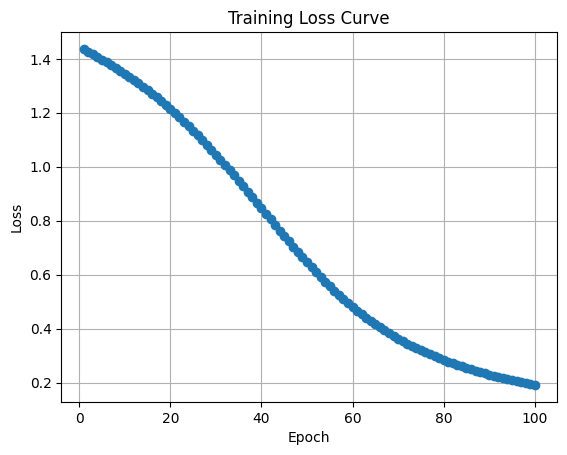

In [83]:
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

/var/folders/_3/_nd7tv0d2gsfqkjz0fh2slbw0000gn/T/ipykernel_37349/3123502946.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)


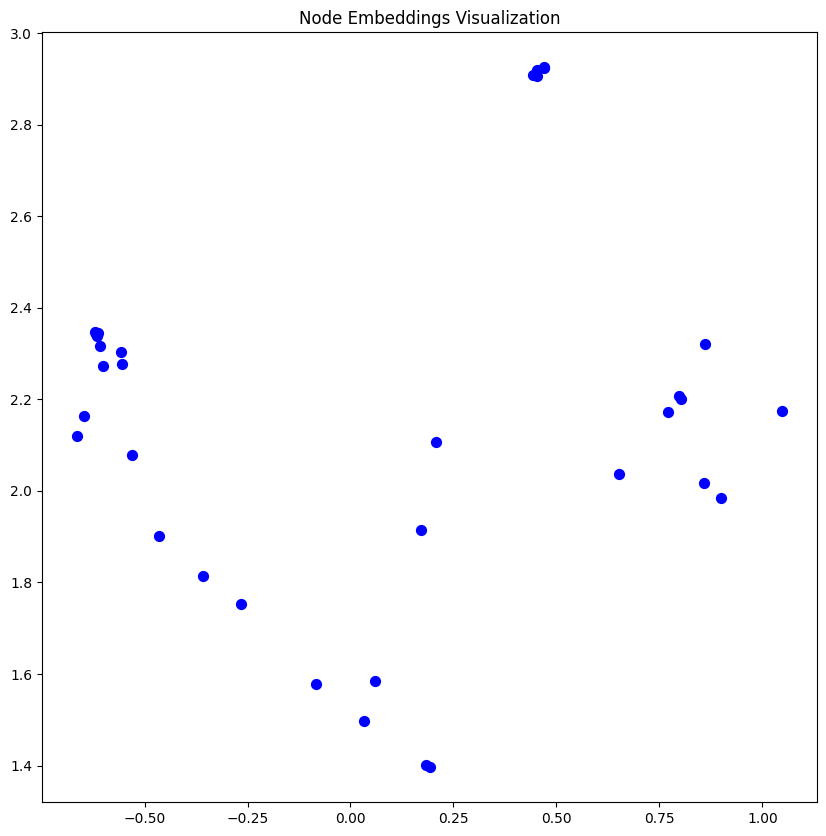

In [84]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)
plt.title("Node Embeddings Visualization")
plt.show()